<a href="https://colab.research.google.com/github/Galdina/FS_capstone/blob/master/Find_your_recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Abstact**

This project offers a journey in the recipes recommendation system using machine learning algorithm. System build on recipes from the food.com website.

![](https://img.sndimg.com/food/image/upload/w_621,h_349,c_fill,fl_progressive,q_80/v1/img/recipes/53/64/42/K53sfuyrS8ikMAWMYSSL_GKGP_Grilling-Party-Fattoush_04-16x9.jpg)

# Introduction, Motivation and Problem Definition

What should I eat? This is a common problem, which many people face daily. Even if they prefer to eat home cooked healthy meals many feel they have no option but to turn to restaurants or fast food due to lack of ideas or time . 

In order to solve this problem, we can gather data from user input and compare it to recipes listed on food.com. From this we can create an algorithm to provide meal recipe recommendations to the user.

The parameters we will be working with are:

* the amount of time the recipe takes to prepare
* the cuisine desired by the user
* the ingredients available on hand
* the amount of nutrition

With this data we can build a recommender system in which the user inputs the amount of time they have available and the desired cuisine from any world region they desire. Based on these inputs we will generate a short list of recipes that fit their preferences.


# Project setup
* Connect to GPU
* Necessary Libraries
* Path for files


## Connect to GPU


In [1]:
#run GPU for this notebook
!nvidia-smi

Thu Jul 30 12:56:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# check devices
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Read data from files
For this project I use data set from [food.com](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions)
* PP_recipes.csv
* PP_user.csv
* RAW_interactions.csv
* RAW_recipes.csv
* ingr_map.pkl

In [3]:
# set the path to the data files
file_folder = '/content/drive/My Drive/capstone/food_com/data/'
# file_folder = './data/' #for local version

# list of files in our dataset
file_names = ['PP_recipes.csv', 'PP_users.csv','RAW_interactions.csv','RAW_recipes.csv', 'ingr_map.pkl']
print(len(file_names))

5


## Import nessasary libraries

In [6]:
# import nessasary libraries
# Packages to read and work with data
import json
import pandas as pd
import numpy as np
import codecs
import gc, sys
import random

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
from tqdm.notebook import tqdm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Handling of text data
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import defaultdict
from nltk.corpus import stopwords 

# for timing code to assess performance
import time

# for ML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix

# set up for data frames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 500

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# define read file functions 
def read_to_df(file_name):
  if file_name[-3:]=='csv':
    data = pd.read_csv(file_folder + file_name)
  if file_name[-3]=='pkl':
    data = pd.read_pickle(file_folder + file_name)  
  return data

## Obtain Data

The dataset are taken from Kaggle. They contaion information concercing the rating given by users to cooking recipeas on the website food.com
They also include various attributes of the recipe such as the name, the time in takes to cook, the ingredients used, the calorie level, the technigue to execute it, the number of steps and even some tags. 


### 1. recipes

In [59]:
pp_recipes = read_to_df(file_names[0])
print(pp_recipes.shape)
print(pp_recipes.info())

(178265, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178265 entries, 0 to 178264
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 178265 non-null  int64 
 1   i                  178265 non-null  int64 
 2   name_tokens        178265 non-null  object
 3   ingredient_tokens  178265 non-null  object
 4   steps_tokens       178265 non-null  object
 5   techniques         178265 non-null  object
 6   calorie_level      178265 non-null  int64 
 7   ingredient_ids     178265 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.9+ MB
None


In [12]:
pp_recipes.head(5)

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


### 2. users

In [60]:
pp_users = read_to_df(file_names[1])
print(pp_users.shape)
print(pp_users.info())

(25076, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25076 entries, 0 to 25075
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   u           25076 non-null  int64 
 1   techniques  25076 non-null  object
 2   items       25076 non-null  object
 3   n_items     25076 non-null  int64 
 4   ratings     25076 non-null  object
 5   n_ratings   25076 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB
None


In [17]:
pp_users.head(5)

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


### 3. interactions
Table contain reviews about recipes

In [61]:
raw_interactions = read_to_df(file_names[2])
print(raw_interactions.shape)
print(raw_interactions.info())

(1132367, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB
None


In [19]:
raw_interactions.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


### 4. recipes with description
Table contain all info about recipes

In [7]:
raw_recipes = read_to_df(file_names[3])
print(raw_recipes.shape)
print(raw_recipes.info())

(231637, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB
None


In [21]:
raw_recipes.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [111]:
l = []
for i in range(0,raw_recipes.shape[0]):
  l.append(raw_recipes['tags'][i].replace('\'','').replace('[','').replace(']',''))
print(l[50000],type(l[50000]))

60-minutes-or-less, time-to-make, course, preparation, 5-ingredients-or-less, desserts, oven, easy, cookies-and-brownies, dietary, equipment <class 'str'>


In [125]:
m = []
for el in l:
  for e in el.split(', '):
    m.append(e)

'low-in-something'

In [157]:
from collections import Counter
k = zip(Counter(m).keys(), Counter(m).values())
tags = pd.DataFrame(k, columns=['tag','count'])
# change datatype for column count
tags['count'].astype(int)
# check how many unique
tags.shape

(552, 2)

In [158]:
tags.head()

,tag,count
0,60-minutes-or-less,69990
1,time-to-make,225326
2,course,218148
3,main-ingredient,170446
4,cuisine,91165


In [180]:
tags[(tags.tag=='time-to-make')|(tags['tag'] == 'cuisine')|(tags['tag'] == 'main-ingredient')|(tags['tag'] == 'course')]

,tag,count
1,time-to-make,225326
2,course,218148
3,main-ingredient,170446
4,cuisine,91165


In [159]:
tags.sort_values(by=['count'])

,tag,count
551,roast-beef-comfort-food,1
525,high-in-something-diabetic-friendly,1
524,middle-eastern-main-dish,1
522,cabbage,1
520,lasagne,1
519,desserts-easy,1
518,desserts-fruit,1
516,pork-crock-pot,1
515,beef-barley-soup,1
514,mushroom-soup,1


In [160]:
tags.loc[tags['count'] < 5, ['tag', 'count']].sort_values(by=['count'])

,tag,count
522,cabbage,1
526,dips-summer,1
527,black-bean-soup,1
528,bean-soup,1
529,served-hot-new-years,1
530,ham-and-bean-soup,1
531,lamb-sheep-main-dish,1
533,for-large-groups-holiday-event,1
534,stews-poultry,1
535,pasta-rice-and-grains-elbow-macaroni,1


In [187]:
meat = ['bacon','beef-ribs','pork-ribs','chicken']
cuisine = ['african', 'asian', 'australian', 'european', 'filipino', 'indian', 
           'iranian-persian', 'italian', 'mexican', 'middle-eastern', 'north-american', 'south-american', 
           'south-west-pacific', 'chinese', 'thai',  'american',   'hawaiian']
len(cuisine)           

17

In [189]:
tags[(tags.tag=='african')|(tags['tag'] == 'asian')|(tags['tag'] == 'australian')|(tags['tag'] == 'european')|
     (tags['tag'] == 'filipino')|(tags['tag'] == 'indian')|(tags['tag'] == 'iranian-persian')|(tags['tag'] == 'italian')|(tags['tag'] == 'mexican')|
     (tags['tag'] == 'middle-eastern')|(tags['tag'] == 'north-american')|(tags['tag'] == 'south-american')|(tags['tag'] == 'south-west-pacific')
     |(tags['tag'] == 'chinese')|(tags['tag'] == 'thai')|(tags['tag'] == 'american')|(tags['tag'] == 'hawaiian')]

,tag,count
7,north-american,48479
10,mexican,6694
24,american,31179
73,south-west-pacific,3934
74,hawaiian,444
133,asian,13485
134,indian,2708
169,european,24912
171,italian,7410
218,chinese,2008


In [ ]:
preferences = ['bake', 'fry', 'grill', 'none']
dish_type  = ['cocktails',]
bake_relative = ['preheat', 'bake', 'oven', 'heat', 'stew', 'microwave']
fry_relative = ['fry', 'sizz', 'saute', 'frizz']
grill_relative = ['grill', 'barbecue', 'roast', 'sear']
cuisine = ['african','indian', 'mexican', 'chinese', 'thai', 'italian', 'american', 'asian', 'middle-eastern', 'hawaiian', 'european','north-american']
dish_styles = ['main-dish','desserts','frozen-desserts','appetizers','side-dishes','beverages','seasonal','soups-stews','brunch']
cooking_time = ['60-minutes-or-less',]

### 5. ingredients

In [41]:
ingr_map = pd.read_pickle(file_folder + 'ingr_map.pkl')
print(ingr_map.shape)
print(ingr_map.info())

(11659, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11659 entries, 0 to 11658
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_ingr   11659 non-null  object
 1   raw_words  11659 non-null  int64 
 2   processed  11659 non-null  object
 3   len_proc   11659 non-null  int64 
 4   replaced   11659 non-null  object
 5   count      11659 non-null  int64 
 6   id         11659 non-null  int16 
dtypes: int16(1), int64(3), object(3)
memory usage: 660.4+ KB
None


In [42]:
ingr_map.head(5)

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308


## Clean Data


In [48]:
def find_miss_values(df):
    if(df.isnull().values.any()): 
        columns = df.columns
        for column in columns:
            df[df[column].isnull()] = ""
            df[df[column]=='NaN'] = ""
            df[pd.isna(df[column])] = ""
    return df.shape

In [46]:
for name in file_names:
  print(name[0:-4:].lower())

pp_recipes
pp_users
raw_interactions
raw_recipes
ingr_map


In [49]:
print(find_miss_values(pp_recipes))
print(find_miss_values(pp_users))
print(find_miss_values(raw_interactions))
print(find_miss_values(raw_recipes))
print(find_miss_values(ingr_map))

(178265, 8)
(25076, 6)
(1132367, 5)
(231637, 12)
(11659, 7)


In [101]:
def data_clean(df):
    #df = pd.read_csv(file_folder+'/RAW_recipes.csv')
    #df=df[:100]
    df['ingredients'] = df.ingredients.str[1:-1].str.split(',').tolist()
    df = df.drop(columns=['name'])
    preferences = ['bake', 'fry', 'grill', 'none']
    bake_relative = ['preheat', 'bake', 'oven', 'heat', 'stew', 'microwave']
    fry_relative = ['fry', 'sizz', 'saute', 'frizz']
    grill_relative = ['grill', 'barbecue', 'roast', 'sear']
    cuisine = ['indian', 'mexican', 'chinese', 'thai', 'italian', 'american', 'asian', 'middle-eastern', 'hawaiian', 'european','north-american']
    #cuisine = ['african', 'asian', 'australian', 'european', 'filipino', 'indian', 
    #       'iranian-persian', 'italian', 'mexican', 'middle-eastern', 'north-american', 'south-american', 
    #       'south-west-pacific', 'chinese', 'thai',  'american',   'hawaiian']
    dish_styles = ['main-dish','desserts','frozen-desserts','appetizers','side-dishes','beverages','seasonal','soups-stews','brunch']
    for index, row in df.iterrows():
        s1 = str(row['steps'])
        s2 = str(row['tags'])
        for s in cuisine:
            if s in s2:
                df.loc[index, 'cuisine'] = s
                break
        for s in dish_styles:
            if s in s2:
                df.loc[index, 'dish_style'] = s
                break
            elif '15-minutes-or-less' in s2:
                df.loc[index, 'dish_style'] = 'side-dishes'
            else:
                df.loc[index, 'dish_style'] = 'unknown'
        for s in bake_relative:
            if s in s1:
                df.loc[index, 'style'] = "bake"
                break
        for s in fry_relative:
            if s in s1:
                df.loc[index, 'style'] = "fry"
                break
        for s in grill_relative:
            if s in s1:
                df.loc[index, 'style'] = "grill"
                break
        if pd.isna(df.loc[index, 'style']):
            df.loc[index, 'style'] = "any"

        split_nut = (df.loc[index, 'nutrition'])[1:-1].split(",")
        sum_cal = (sum(float(s) for s in split_nut))
        if sum_cal < 250:
            df.loc[index, 'nutrition'] = "low"
        elif 250 <= sum_cal < 500:
            df.loc[index, 'nutrition'] = "medium"
        elif sum_cal >= 500:
            df.loc[index, 'nutrition'] = "high"
    df.set_index('id')
    df = df.dropna()
    df = df.drop(columns=['steps'])
    df = df.drop(columns=['n_steps'])
    df = df.drop(columns=['n_ingredients'])
    df = df.drop(columns=['tags'])
    #df.to_json('./data/data.json', orient='records')
    print(df.head())
  return df


In [51]:
dc = data_clean(raw_recipes)

       id  minutes  contributor_id  ...   cuisine   dish_style style
0  137739       55           47892  ...   mexican  side-dishes  bake
1   31490       30           26278  ...  american    main-dish  bake
4   44061      190           41706  ...  american      unknown   any
6   25274       15           21730  ...  american   appetizers   any
7   67888      120           10404  ...  american    main-dish  bake

[5 rows x 10 columns]


In [ ]:
# save clean data into json files
dc.to_json(file_folder+'data.json', orient='records')

# Exploratory Data Analysis


In [113]:
df = pd.read_json('/content/drive/My Drive/capstone/food_com/data/data_c.json')

Cuisine Categories in the dataset (by occurence):
american          42455
european          14926
asian              7507
italian            7390
mexican            6693
indian             2708
chinese            2004
thai               1175
middle-eastern      378
hawaiian            255
Name: cuisine, dtype: int64

There are 10 cuisine categories represented in this dataset.


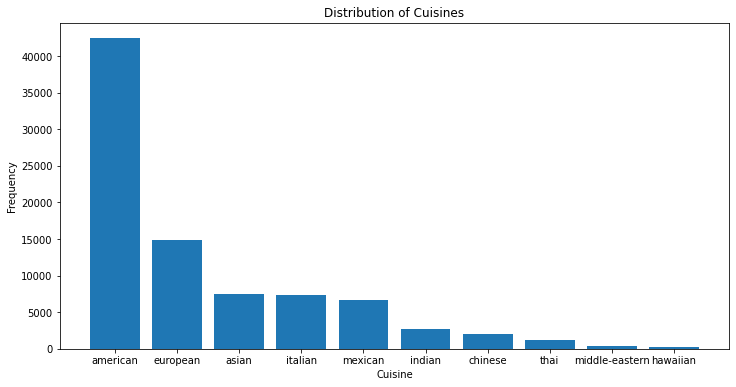

In [108]:
# Display the list of cuisines that appear in the dataset
print('Cuisine Categories in the dataset (by occurence):')
print(df.cuisine.value_counts())

print('\nThere are {0} cuisine categories represented in this dataset.'.format(df.cuisine.value_counts().shape[0]))

# plot distribution of cuisine categories
plt.subplots(figsize=(12, 6))
plt.bar(range(len(df.cuisine.value_counts().index)), df.cuisine.value_counts())
plt.title('Distribution of Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Frequency')
plt.xticks(range(len(df.cuisine.value_counts().index)), df.cuisine.value_counts().index, rotation='horizontal')

plt.show()

We can see that some categories, such as American and European Cuisines occupy much larger fractions of the data, but overall there aren't any cuisines with overly small amounts of recipes represented here.

Next we will take a look at the ingredient details. First, we will look at the statistics of overall length of the ingredients list for each entry.

In [86]:
df.ingredients

0        ['winter squash',  'mexican seasoning',  'mixe...
1        ['prepared pizza crust',  'sausage patty',  'e...
2        ['tomato juice',  'apple cider vinegar',  'sug...
3        ['milk',  'vanilla ice cream',  'frozen apple ...
4        ['fennel seeds',  'green olives',  'ripe olive...
                               ...                        
85486    ['butter',  'onions',  'flour',  'salt',  'vin...
85487    ['onions',  'red onions',  'fresh garlic',  'o...
85488    ['flour',  'baking powder',  'kosher salt',  '...
85489    ['mayonnaise',  'prepared horseradish',  'worc...
85490    ['celery',  'onion',  'green sweet pepper',  '...
Name: ingredients, Length: 85491, dtype: object

In [115]:
# remove quotation for ingredients
df['ingredients'] = df['ingredients'].map(lambda x: [y.replace("\  '",'') for y in x])#.applymap(lambda x: x.replace('\'',''))
df['ingredients'] = df['ingredients'].map(lambda x: [y.replace("\ '",'') for y in x])#.applymap(lambda x: x.replace('\'',''))
df['ingredients'] = df['ingredients'].map(lambda x: [y.replace('\"','') for y in x])#.applymap(lambda x: x.replace('\'',''))
df['ingredients'] = df['ingredients'].map(lambda x: [y.replace("\'",'') for y in x])#.applymap(lambda x: x.replace('\'',''))

df.head(5)

,id,minutes,nutrition,ingredients,cuisine,dish_style,style
0,137739,55,low,"[winter squash, mexican seasoning, mixed spi...",mexican,side-dishes,bake
1,31490,30,medium,"[prepared pizza crust, sausage patty, eggs, ...",american,main-dish,bake
2,44061,190,high,"[tomato juice, apple cider vinegar, sugar, ...",american,unknown,any
3,5289,0,medium,"[milk, vanilla ice cream, frozen apple juice...",american,beverages,any
4,25274,15,high,"[fennel seeds, green olives, ripe olives, g...",american,appetizers,any


count    85491.000000
mean         9.657040
std          3.943976
min          1.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         38.000000
dtype: float64

 Median Value: 9.0


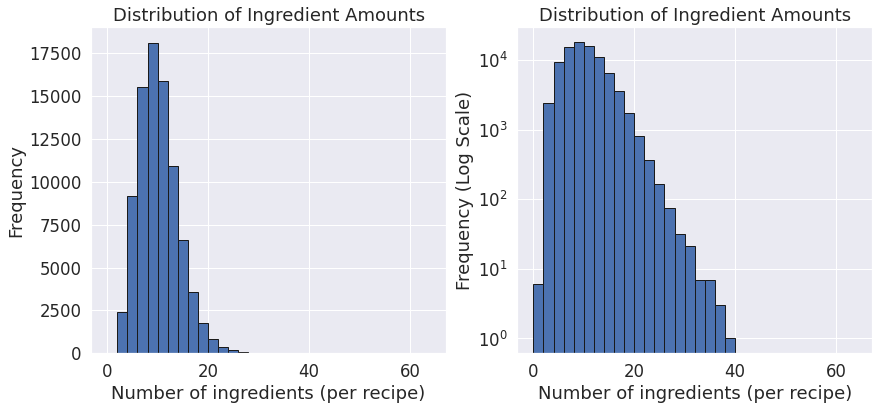

In [174]:
# Create a list of lengths of ingredients for each recipe
ingredients_len = []
for i in range(df.shape[0]):
    ingredients_len.append(len(df.ingredients[i]))

ingredients_len = pd.Series(ingredients_len)

# Display statistics of lengths of ingredients
print(ingredients_len.describe())
print('\n Median Value: {0}'.format(ingredients_len.median()))

plt.subplots(figsize=(14,6))
bins = range(0, 66, 2)

plt.subplot(1, 2, 1)
ingredients_len.hist(edgecolor='k', bins=bins)
plt.ylabel('Frequency')
plt.xlabel('Number of ingredients (per recipe)')
plt.title('Distribution of Ingredient Amounts')

plt.subplot(1, 2, 2)
ingredients_len.hist(edgecolor='k', bins=bins)
plt.yscale('log')
plt.ylabel('Frequency (Log Scale)')
plt.xlabel('Number of ingredients (per recipe)')
plt.title('Distribution of Ingredient Amounts')

plt.show()

There is quite a large variation in the number of ingredients per recipe, with a maximum of 38 in this dataset. The average tends to be about 10 ingredients per recipe. Surprisingly, there are recipes with only 1 ingredient! We can see the ingredients for these below.



In [116]:
# Display cuisine and ingredient lists for recipes with only 1 ingredient
for i in range(df.shape[0]):
    if len(df.ingredients[i]) == 1:
        print(df.cuisine[i], df.ingredients[i])

european ['heavy cream']
asian ['white bread']
american ['jelly beans']
european ['white bread']
american ['white sugar']
american ['sweetened condensed milk']


In [133]:
# Create a set for holding only unique ingredients
ingredients_set = set()

# Create a list for holding all ingredients
ingredients_combined = []

# Populate set and list
for i in range(df.shape[0]):
    ingredients_set.update(df.ingredients[i])
    ingredients_combined.extend(df.ingredients[i])


# Create a ranking of most common ingredients
ingredient_rankings = pd.Series(ingredients_combined).value_counts()
    
# Display information about the ingredients
print('Number of unique ingredients in the dataset: {0}'.format(len(ingredients_set)))
print('Number of total ingredients in the dataset: {0}'.format(len(ingredients_combined)))
print('\nIngredients ranked by occurence in the data:')
print(ingredient_rankings[0:15] )

Number of unique ingredients in the dataset: 16766
Number of total ingredients in the dataset: 825590

Ingredients ranked by occurence in the data:
 salt               33387
 onion              15881
 butter             14719
 sugar              14653
 water              13138
 garlic cloves      11891
 olive oil          10934
 eggs                9964
 pepper              8688
 garlic              8277
 milk                8059
 flour               7436
 salt and pepper     6325
 egg                 5492
 black pepper        5491
dtype: int64


In [132]:
# Populate set and list
for i in range(10):
    ingredients_set.update(df.ingredients[i])
    #print(df.ingredients[i])
    ingredients_combined.extend(df.ingredients[i])
for i in ingredients_combined[1:10]:#range(len(ingredients_combined)):
  i.replace(" ","")
  i.strip()
  print(i)

 mexican seasoning
 mixed spice
 honey
 butter
 olive oil
 salt
prepared pizza crust
 sausage patty
 eggs


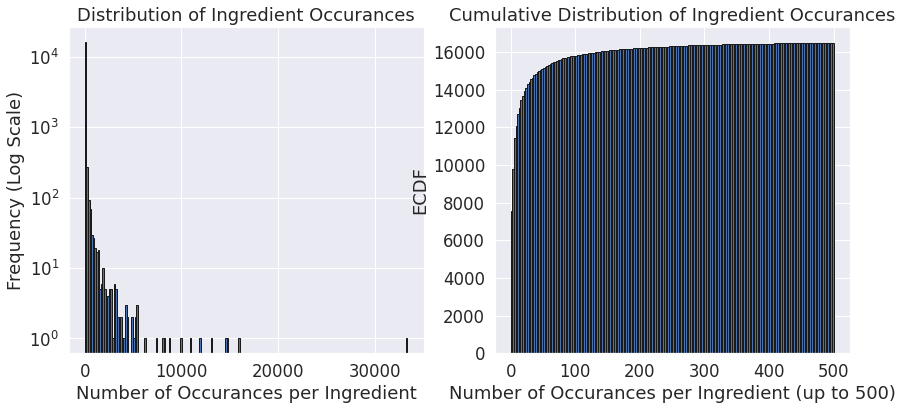

In [171]:
# Plot total distribution of ingredient occurences
plt.subplots(figsize=(14,6))
plt.subplot(1, 2, 1)
ingredient_rankings.hist(bins=200, edgecolor='k')
plt.xlabel('Number of Occurances per Ingredient')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log')
plt.title('Distribution of Ingredient Occurances')

# Plot ECDF of ingredient occurences
plt.subplot(1, 2, 2)
ingredient_rankings.hist(bins=200, edgecolor='k', cumulative=True, range=[0,500])
plt.xlabel('Number of Occurances per Ingredient (up to 500)')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Ingredient Occurances')

plt.show()


We can see that while salt is almost ubiquitous, less than half of our ingredients show up more than a few times each. This will need to be addressed, since it may make building a predictive model very difficult. One reason for this is that many similar ingredients have many variants, as is shown below for ingredients containing "Turkey".

In [178]:
# Handling of text data
import re
total_chicken = 0
i = 0
for ingredient in ingredients_set:
    if re.search(r" chicken", ingredient):
        total_chicken += ingredient_rankings.loc[ingredient]
        print('{0}: {1}'.format(ingredient, ingredient_rankings.loc[ingredient]))
        i +=1
print('Number of Turkey variations: {0}'.format(i))
print('Total times ingredients with Turkey were used: {0}'.format(total_chicken))


 chicken bouillon cube: 123
 vegan chicken seasoning: 3
 whole boneless skinless chicken breast: 3
 roasted chicken meat: 2
 butter chicken paste: 1
 roasting chickens: 36
 grilled chicken breast strips: 2
 chicken fillet: 3
skinless chicken breasts: 72
boneless skinned chicken breast: 1
 fat-free cream of chicken soup: 7
 chicken halves: 3
 low-sodium chicken stock: 5
 chicken flavor stuffing mix: 15
 skinless chicken legs: 5
andouille chicken sausage: 1
 whole chicken: 33
 chicken gravy: 5
 chicken feet: 1
 chicken bouillon: 98
 lean ground chicken: 12
fryer chicken: 1
 chicken frankfurters: 2
lipton instant chicken soup mix: 1
 mccormicks chicken stir-fry seasoning packet: 1
 vegetarian chicken flavored broth mix: 2
 chicken heart: 2
boneless chicken thighs: 27
 whole boneless skinless chicken breasts: 2
 cooked italian chicken breasts: 1
vegetarian chicken strips: 3
 low-sodium condensed cream of chicken soup: 1
 whole chickens: 50
boneless chicken breast: 46
 extra-strong chicken 

In [186]:
# Initialize a lemmatizer to produce the singular forms of nouns
wnl = WordNetLemmatizer()

# Initialize list for simple ingredient labels
simple_ingredients = []

# Identify words that wordnet has difficulty with to make sure they are excluded or not excluded from the ingredients
words_to_exclude = set(['sodium', 'ground', 'boneless', 'skinless', 'kosher', '%', 'cloves'])
words_to_include = set(['sour', 'garlic', 'pepper', 'olive', 'vegetable'])

# Print a header for list of ingredients that yield no simplified form
print('List of ingredients with no simplified form found:')

# Loop through 
for ingredient in ingredient_rankings.index:
    # tokenize ingredient
    ing_tokenized = word_tokenize(ingredient.lower())
    
    # Remove verbs (makes noun processing a little easier)
    no_verbs = [word for (word, pos) in pos_tag(ing_tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]
    
    # Extract singular form of nouns left in the ingredient
    nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]
    
    # If the string is empty, print the ingredient
    if len(nouns) == 0:
        print(ingredient)
    
    # Add to simple ingredients list
    simple_ingredients.append(' '.join(nouns))

List of ingredients with no simplified form found:
 ground cloves
 shortening
 cloves
 plain flour
 whole cloves
 gruyere cheese
 seasoning
shortening
plain flour
 couscous
 whipped topping
 gruyere
 self raising flour
 self rising flour
couscous
self raising flour
 non-dairy whipped topping
 icing
self rising flour
 jelly
 frosting
 ground aniseed
 hing
 blackening seasoning
 fat-free whipped topping
 israeli couscous
 flavoring
 dripping
 7-up
 cooked couscous
gruyere cheese
 endive
cloves
 sweet n low
kingfish
seasoning
 japanese sake
gruyere
endive
 pudding
 casing
whipped topping
israeli couscous
 knockwurst
 caerphilly cheese
whole cloves
 pickled herring
 other seasoning
 roasted pecan
ground cloves
 simply macaroni & cheese
dried lily buds
dripping
caerphilly cheese
 diet 7-up
 instant couscous
 quick-cooking couscous
 light non-dairy whipped topping
japanese sake
 smoked gruyere cheese
non-dairy whipped topping
pudding
ground moose
cooked couscous
simply macaroni & cheese
blac

In [78]:
#import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('universal_tagset')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [187]:
# Add terms to words_to_include
words_to_include.update(['shortening', 'flour', 'couscous', 'seasoning', 'cheese', 'dressing', 'radish', 'jelly', 'stuffing', 'ham', 'flaxseed', 'pudding', 'icing', 'frosting', 'topping'])

# Make second draft of simplified ingredients
simple_ingredients2 = []

# Print a header for list of ingredients that yield no simplified form
print('List of ingredients with no simplified form found:')

# Loop through 
for ingredient in ingredient_rankings.index:
    # tokenize ingredient
    ing_tokenized = word_tokenize(ingredient.lower())
    
    # Remove verbs (makes noun processing a little easier)
    no_verbs = [word for (word, pos) in pos_tag(ing_tokenized, tagset='universal') if pos!='VERB' and word not in words_to_exclude or (word in words_to_include)]
    
    # Extract singular form of nouns left in the ingredient
    nouns = [wnl.lemmatize(word) for (word, pos) in pos_tag(no_verbs, tagset='universal') if pos=='NOUN' or word in words_to_include]
    
    # If the string is empty, print the ingredient and set the simplified ingredient to 'other'
    if len(nouns) == 0:
        print(ingredient)
        simple_ingredients2.append('other')
    else:
        # Add to simple ingredients list
        simple_ingredients2.append(' '.join(nouns))

List of ingredients with no simplified form found:
 ground cloves
 cloves
 whole cloves
 gruyere
 ground aniseed
 hing
 flavoring
 dripping
 7-up
 endive
cloves
 sweet n low
kingfish
 japanese sake
gruyere
endive
 casing
 knockwurst
whole cloves
 pickled herring
 roasted pecan
ground cloves
dried lily buds
dripping
 diet 7-up
japanese sake
ground moose
casing
 lime cordial
diet 7-up
 dried lily buds
 mastic
 nixtamal
 durian


In [188]:
print(len(ingredient_rankings),len(simple_ingredients2))

16766 16766


In [189]:
# Create a dataframe to preview changes in ingredients
compare_ingredients_test = pd.DataFrame(data={'original ingredients': ingredient_rankings.index, 'simplified': simple_ingredients2})
print(compare_ingredients_test[:30])

# Print out reduction in unique ingredients
print('\nAfter 1st Step: Unique ingredients reduced from {0} to {1}'.format(compare_ingredients_test.shape[0], len(set(compare_ingredients_test.simplified))))

   original ingredients     simplified
0                  salt           salt
1                 onion          onion
2                butter         butter
3                 sugar          sugar
4                 water          water
5         garlic cloves         garlic
6             olive oil      olive oil
7                  eggs            egg
8                pepper         pepper
9                garlic         garlic
10                 milk           milk
11                flour          flour
12      salt and pepper    salt pepper
13                  egg            egg
14         black pepper         pepper
15          brown sugar    brown sugar
16      parmesan cheese         cheese
17             tomatoes         tomato
18        vegetable oil  vegetable oil
19          lemon juice    lemon juice
20        baking powder         powder
21            soy sauce      soy sauce
22    all-purpose flour          flour
23               onions          onion
24           sour cream  

In [190]:
df.cuisine.value_counts()

american          42455
european          14926
asian              7507
italian            7390
mexican            6693
indian             2708
chinese            2004
thai               1175
middle-eastern      378
hawaiian            255
Name: cuisine, dtype: int64

1. What are the most frequently used ingredients in each cuisine?
We can get an idea of the ingredients used in each cuisine by splitting ingredients and words by categories.

In [140]:
# Create a list to hold separated ingredients and word lists for each cuisine
cuisines = list(df.cuisine.value_counts().index)

# loop through each entry and separate entries by cuisine
i = 0
for cuisine in df.cuisine.value_counts().index:
    cuisines[i] = df[df.cuisine == cuisine]
    i += 1

In [141]:
cuisines[1].head()

,id,minutes,nutrition,ingredients,cuisine,dish_style,style
14,26995,14450,high,"[flour, water, dry yeast, milk, sugar, eggs, vegetable oil, baking soda, baking powder, salt, cinnamon, vanilla, crushed pineapple, raisins, nuts, butter, brown sugar]",european,unknown,bake
16,24478,20160,low,"[fresh herbs, cider vinegar, fresh herb]",european,unknown,any
21,43164,120,high,"[veal roast, butter, oil, carrots, onions, parsley sprigs, bay leaf, thyme, salt, pepper, bacon]",european,main-dish,grill
41,105069,40,medium,"[wild mushrooms, onions, butter, lemon, juice of, water, beef broth, sour cream, flour, salt and pepper, fresh dill]",european,soups-stews,fry
54,503475,50,high,"[eggs, milk, flour, sugar, salt, cream, apples, butter, cinnamon, lemon, juice of]",european,unknown,fry


In [142]:
cuisine_ingredients = defaultdict(list)
cuisine_words = defaultdict(list)
world_ingredients = []

for category in cuisines:
    cuisine = category.cuisine.head(1).values[0]
    for ingredients in category.ingredients:
        cuisine_ingredients[cuisine] += ingredients
        
for i in df.ingredients:    
    world_ingredients.extend(i)

## Some Words Cloud

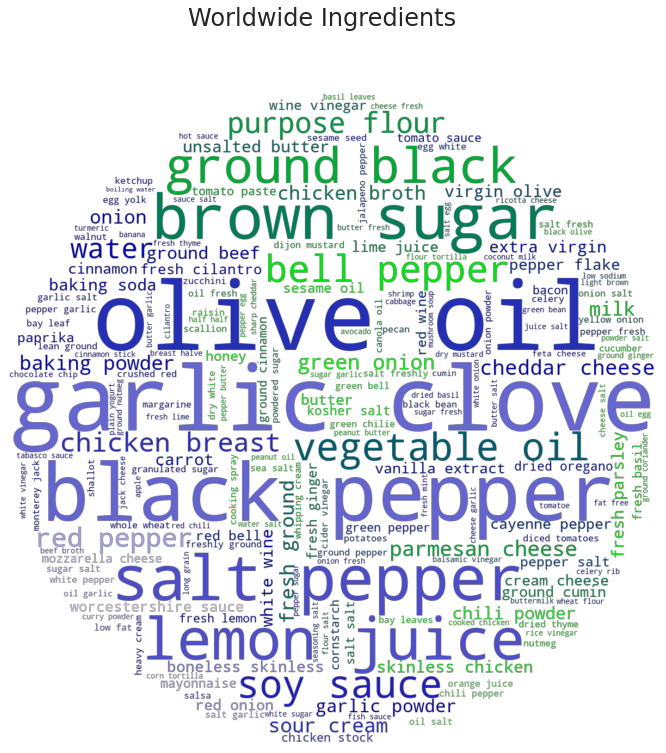

In [200]:
# Create a wordcloud to show most common ingredients worldwide
text = ', '.join(sample(world_ingredients, len(world_ingredients)))

# load data for mask
mask = np.array(Image.open(file_folder+'/masks/world.jpg'))
image_colors = ImageColorGenerator(mask)

# Generate wordcloud using text
wc = WordCloud(background_color=None,
               mode='RGBA',
               color_func=image_colors,
               mask=mask).generate(text)

# create plot of wordcloud
plt.subplots(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.suptitle('Worldwide Ingredients', fontsize=24)
plt.axis("off")

# Save the wordcloud to a file
#plt.savefig('data/wordclouds/world.png', format='png', dpi=100)

plt.show()

In [143]:
# create dictionary for colormaps of each cuisine place of origin
cuisine_colors = dict(zip(cuisine_ingredients.keys(), ['RdYlGn', 'RdYlGn', 'seismic', 'BrBG',
                                                       'autumn', 'seismic', 'Blues', 'coolwarm',
                                                       'Reds', 'Blues', 'autumn', 'bwr', 'autumn',
                                                       'RdYlGn', 'bwr', 'RdYlBu', 'BrBG', 'summer',
                                                       'coolwarm', 'summer']))

In [153]:
#   create word clouds based on term frequency and cuisine category
def make_word_clouds(cuisine_list, dictionary, cuisine_colors=cuisine_colors):
    for i in range(len(cuisine_list)):
        # Combine all ingredients into single string
        to_shuffle = dictionary[cuisine_list[i]]
        random.shuffle(to_shuffle)
        text = ', '.join(to_shuffle)

        # load data from path
        open_path = file_folder + 'masks/' + cuisine_list[i] + '.jpg'
        mask = np.array(Image.open(open_path))
        
        # Generate wordcloud using text
        wc = WordCloud(background_color=None,
                       mode='RGBA',
                       colormap=cuisine_colors[cuisine_list[i]],
                       mask=mask).generate(text)

        # create plot of wordcloud
                # create plot of wordcloud
        plt.subplots(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.suptitle(cuisine_list[i].title(), fontsize=24)
        plt.axis("off")
        
        # Save the wordcloud to a file
       # save_path = 'data/wordclouds/' + cuisine_list[i] + '.png'
        #plt.savefig(save_path, format='png', dpi=100)

        plt.show()

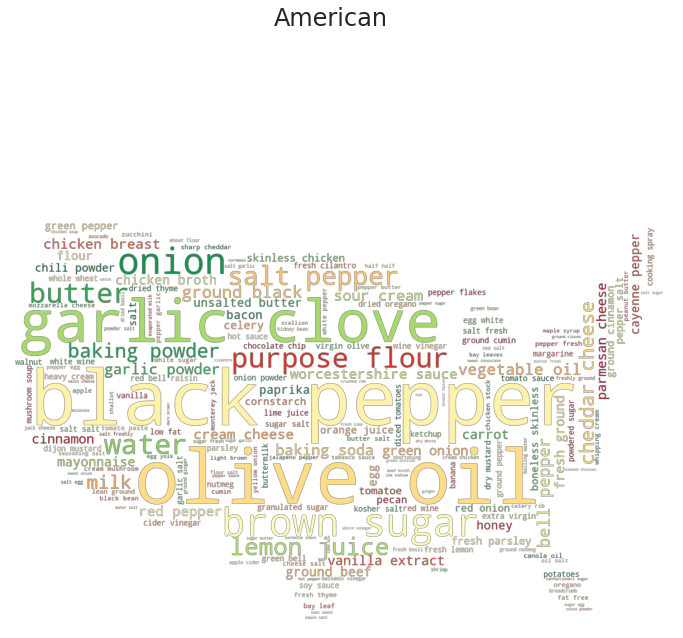

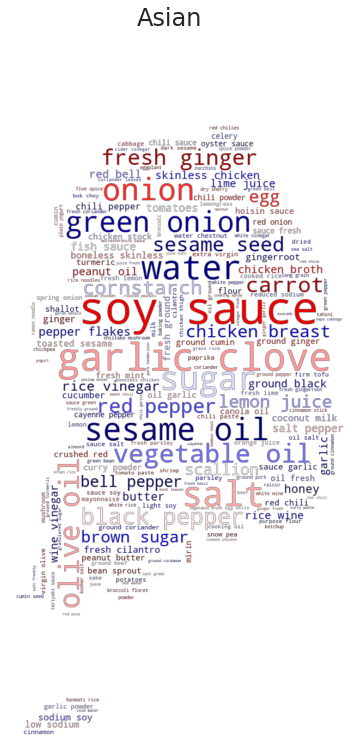

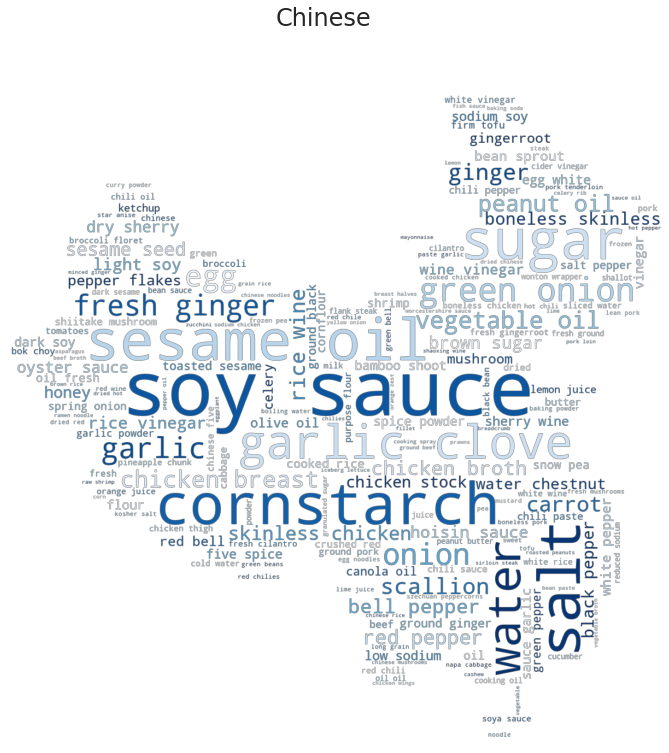

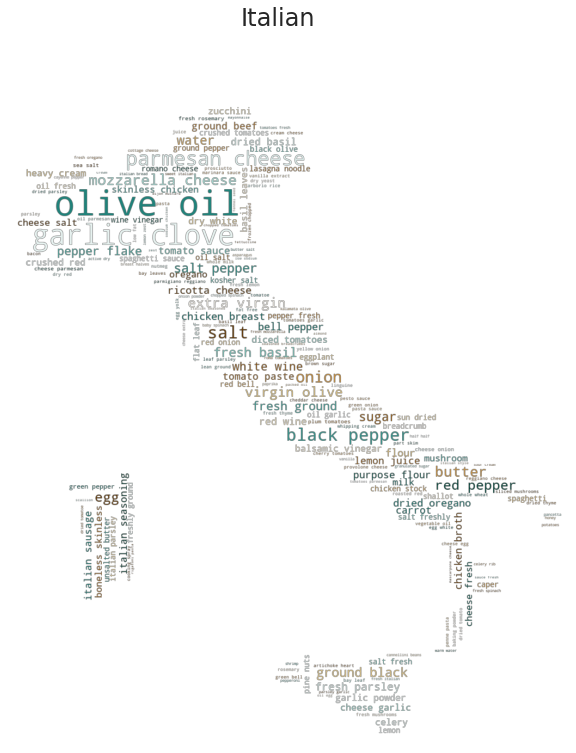

In [156]:
cuisine_list = list(cuisine_ingredients.keys())
cuisine_list
make_word_clouds(['american','asian','chinese','italian'], cuisine_ingredients)

In [214]:
# Create a dictionary to hold lengths of ingredients
ingredient_lengths = defaultdict(list)

for i in range(len(cuisines)):
    # Identify category of cuisine
    category = cuisines[i].cuisine.head(1).values[0]
    temp_list = []
    # Append lengths of recipes for each cuisine to ingredient_lengths
    for recipe in cuisines[i].ingredients:
        temp_list.append(len(recipe))
        
    ingredient_lengths[category] = temp_list

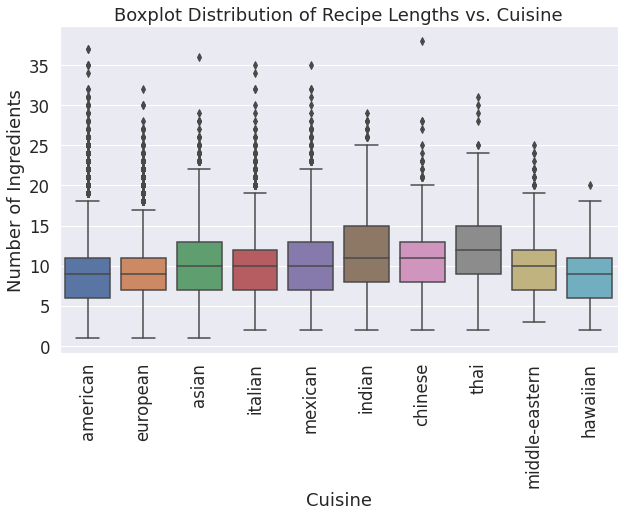

In [215]:
sns.set(font_scale=1.5)

plt.subplots(figsize=(10, 6))
sns.boxplot(data=list(ingredient_lengths.values()))
plt.xticks(range(len(ingredient_lengths.keys())), list(ingredient_lengths.keys()), rotation='vertical')
plt.title('Boxplot Distribution of Recipe Lengths vs. Cuisine')
plt.xlabel('Cuisine')
plt.ylabel('Number of Ingredients')

plt.show()

In [217]:
mean_lengths = []
for key in ingredient_lengths.keys():
    mean_lengths.append(np.mean(ingredient_lengths[key]))

sorted_lengths = [i[0] for i in sorted(enumerate(mean_lengths), key=lambda x:x[1], reverse=True)]
print(sorted_lengths)

sorted_ingredient_keys = [list(ingredient_lengths.keys())[x] for x in sorted_lengths]
print(sorted_ingredient_keys)

sorted_ingredient_lengths = [list(ingredient_lengths[key]) for key in sorted_ingredient_keys]


[7, 5, 6, 2, 3, 8, 4, 1, 0, 9]
['thai', 'indian', 'chinese', 'asian', 'italian', 'middle-eastern', 'mexican', 'european', 'american', 'hawaiian']


In [218]:
# List number of unique ingredients for each cuisine
unique_cuisine_ingredients = defaultdict(int)

for i in range(len(sorted_ingredient_keys)):
    unique_cuisine_ingredients[sorted_ingredient_keys[i]] = len(set(cuisine_ingredients[sorted_ingredient_keys[i]]))

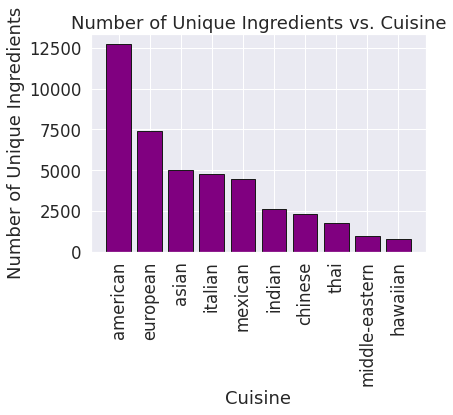

In [219]:
# Generate plot to visualize the unique ingredients per cuisine
unique_cuisine_ingredient_keys = sorted(unique_cuisine_ingredients, key=unique_cuisine_ingredients.get, reverse=True)
unique_cuisine_ingredient_list = [unique_cuisine_ingredients[x] for x in unique_cuisine_ingredient_keys]

plt.bar(range(len(unique_cuisine_ingredient_list)), unique_cuisine_ingredient_list, edgecolor='k', facecolor='purple')
plt.xticks(range(len(unique_cuisine_ingredient_list)), unique_cuisine_ingredient_keys, rotation='vertical')
plt.xlabel('Cuisine')
plt.ylabel('Number of Unique Ingredients')
plt.title('Number of Unique Ingredients vs. Cuisine')
plt.show()

# Create a model


In [8]:

start_time = time.time()
meal_id, cuisine, ingredients, ingre, main_dataset, train_set, test_set = [], [], [], [], [], [], []
predicted_cuisine = ''

In [9]:
# creates all the lists needed for the execution
def lists(filename):
    with codecs.open(filename, encoding='utf-8') as data_file:
        data = json.load(data_file)

    # print(type(data))
    for i in range(0, len(data)):
        meal_id.append(data[i]["id"])
        cuisine.append(data[i]["cuisine"])
        ingredients.append(data[i]["ingredients"])

    for i in ingredients:
        temp = u''
        for j in range(len(i)):
            temp = temp + u" " + i[j]
        ingre.append(temp.encode('utf-8'))
    return meal_id

In [10]:
# vectorizes the columns in the data and convert them into features
def ing_vector(existing, user_ing):
    existing.append(user_ing)
    vector = TfidfVectorizer(use_idf=True, stop_words='english', max_features=1000)
    ing_vect = vector.fit_transform(existing)
    return ing_vect.todense()

In [11]:
# training the knn model for the future prediction
def KNN_trainer(train_set, cuisine, n):
    close = KNeighborsClassifier(n_neighbors=int(n))
    return close.fit(train_set, cuisine)

In [13]:
# user is asked to enter pantry availability and user preferences i.e., cooking style, cooking time, calories level
def KNN_predictor(test_set, close, neighbors):
    neighbors = int(neighbors)
    print("")
    predicted_cuisine = close.predict_proba(test_set)[0]
    predicted_single_cuisine = close.predict(test_set)
    predicted_class = close.classes_
    print("The model predicts that the ingredients resembles %s" % (predicted_single_cuisine[0]))
    print("")
    for i in range(len(predicted_cuisine)):
        if not (predicted_cuisine[i] == 0.0):
            print("The ingredients resemble %s with %f percentage" % (predicted_class[i], predicted_cuisine[i] * 100))

    print("")
    print("The %d closest meals are listed below : " % neighbors)
    match_perc, match_id = close.kneighbors(test_set)
    # print(df.head())
    for i in range(len(match_id[0])):
        id = meal_id[match_id[0][i]]
        # print(type(id))
        # print(id)
        # print(df.index.name)
        # print(df.iloc["id"]["style"])
        # if df.loc([id,'style']) == pref:
        #print(meal_id[match_id[0][i]])
        m = (raw_recipes[raw_recipes['id'] == meal_id[match_id[0][i]]]['name'].to_string(index=False)).title()
        url = 'https://www.food.com/recipe/'
        print(m, url+str(id)) 
        # print(ingredients[match_id[0][i]])
    print("")

    print("--- Search took %s seconds ---" % (time.time() - start_time))
    print("")
    print("")

    return predicted_single_cuisine

In [12]:
import ipywidgets as widgets
# main_func() function handles the sequential execution of the knn trainer and predictor
def main_func():
    user_ing = input("Enter the pantry availability : ")
    main_dataset = ing_vector(ingre, user_ing)
    train_set = main_dataset[:len(main_dataset) - 1]
    test_set = main_dataset[len(main_dataset) - 1]
    #neighbors = input("Enter the number of closest recipes you want to find : ")
    n = widgets.IntSlider(
    value=7,
    min=1,
    max=50,
    step=1,
    description='Enter the number of closest recipes you want to find:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
    )
    display(n)
    neighbors = n.value
    #pref = input("Enter your preferred cooking style:")
    p = widgets.Select(options=['indian', 'mexican', 'chinese', 'thai', 'italian', 'american', 'asian', 'middle-eastern', 'hawaiian', 'european','north-american'],
    value='mexican',
    description='Cuisine:',
    disabled=False
    )
    display(p)
    pref = p.value
    #--------
    time = input("Enter the time limit you have for cooking:")
    nutri = input("Preferred nutrition level(low,medium,high):")
    close = KNN_trainer(train_set, cuisine, neighbors)
    print("Model has been successfully trained..")
    print("Trying to predict the cuisine and n closest recipes...")
    KNN_predictor(test_set, close, neighbors)
    ingre.pop()
    try:
        nextStep = int(input("Enter 'yes' if you want to search again or 'no' if you want to quit.."))
        if not (nextStep == '1' or nextStep == '0'):
            raise ValueError()
        elif (nextStep == '1'):
            main_func()
        elif (nextStep == '0'):
            quit()
    except ValueError:
        print("Invalid Option. Enter correctly")
        #main_func()

In [17]:
meal_id, cuisine, ingredients, ingre, main_dataset, train_set, test_set = [], [], [], [], [], [], []
predicted_cuisine = '' 

In [18]:
if __name__ == '__main__':
    print("Reading all the data files....")
    lists(filename="/content/drive/My Drive/capstone/food_com/data/data_c.json")
    df = pd.read_json('/content/drive/My Drive/capstone/food_com/data/data_c.json')
    #start_time = time.time()
    #meal_id, cuisine, ingredients, ingre, main_dataset, train_set, test_set = [], [], [], [], [], [], []
    #predicted_cuisine = '' 
    #@interact 
    main_func()

Reading all the data files....
Enter the pantry availability : pork, cheese


IntSlider(value=7, continuous_update=False, description='Enter the number of closest recipes you want to find:…

Select(description='Cuisine:', index=1, options=('indian', 'mexican', 'chinese', 'thai', 'italian', 'american'…

Enter the time limit you have for cooking:56
Preferred nutrition level(low,medium,high):low
Model has been successfully trained..
Trying to predict the cuisine and n closest recipes...

The model predicts that the ingredients resembles american

The ingredients resemble american with 42.857143 percentage
The ingredients resemble chinese with 14.285714 percentage
The ingredients resemble european with 42.857143 percentage

The 7 closest meals are listed below : 
 Pork With Garlic https://www.food.com/recipe/256328
 Feijoada   The Real One https://www.food.com/recipe/41842
 Poutine Rapee https://www.food.com/recipe/123966
 Rillettes  Anthony Bourdain At Les Halles https://www.food.com/recipe/319679
 Red Boudin   Boudain Rouge   Cajun Blood Sausage https://www.food.com/recipe/104491
 The Easiest Asian Pork Dinner https://www.food.com/recipe/137872
 English Bangers https://www.food.com/recipe/4203

--- Search took 470.8654508590698 seconds ---


Enter 'yes' if you want to search again or '

In [86]:
f = pd.read_json('/content/drive/My Drive/capstone/food_com/data/data_c.json')
f.head()

Select(description='Cuisine:', index=1, options=('indian', 'mexican', 'chinese', 'thai', 'italian', 'american'…

## Check model accuracy

In [19]:
def KNN_predictor1(test_set, close, neighbors):
    neighbors = int(neighbors)
    print("")
    predicted_cuisine = close.predict_proba(test_set)[0]
    predicted_single_cuisine = close.predict(test_set)
    predicted_class = close.classes_
    print("The model predicts that the ingredients resembles %s" % (predicted_single_cuisine[0]))
    print("")
    for i in range(len(predicted_cuisine)):
        if not (predicted_cuisine[i] == 0.0):
            print("The ingredients resemble %s with %f percentage" % (predicted_class[i], predicted_cuisine[i] * 100))

    print("")
    print("The %d closest meals are listed below : " % neighbors)
    match_perc, match_id = close.kneighbors(test_set)
    # print(df.head())
    for i in range(len(match_id[0])):
        id = meal_id[match_id[0][i]]
        # print(type(id))
        # print(id)
        # print(df.index.name)
        # print(df.iloc["id"]["style"])
        # if df.loc([id,'style']) == pref:
        #print(meal_id[match_id[0][i]])
        #m = (raw_recipes[raw_recipes['id'] == meal_id[match_id[0][i]]]['name'].to_string(index=False)).title()
        #url = 'https://www.food.com/recipe/'
        #print(m, url+str(id)) 
        # print(ingredients[match_id[0][i]])
    #print("")

    #print("--- Search took %s seconds ---" % (time.time() - start_time))
    #print("")
    #print("")

    return predicted_single_cuisine

In [ ]:
import time
start_time = time.time()

per_test = []
per_test_id = []
per_train = []
per_train_id = []
per_train_cuisine = []
per_test_cuisine = []
full_list =[]
ingre = []
print("started")
lists(filename="/content/drive/My Drive/capstone/food_com/data/data_c.json")
full_list = ing_vector(ingre,"\'cabbage\'flour\'carrot\'cheese\'") #"\'onion\' \'carrot\' \'celery\' \'solid pack pumpkin\' \'red bell pepper\'")
print("list completed")

train_list = np.array(full_list)

for i in range(0, len(full_list) - 1):
    if random.random() < 0.95:
        per_train.append(train_list[i])
        per_train_id.append(meal_id[i])
        per_train_cuisine.append(cuisine[i])
    else:
        per_test.append(full_list[i])
        per_test_id.append(meal_id[i])
        per_test_cuisine.append(cuisine[i])

print("Training is starting..")
per_close_n = KNN_trainer(per_train, per_train_cuisine, 5)
print(len(ingre),len(full_list) - 1,len(meal_id),len(per_test))

print("Training completed")
no_of_tests = len(per_test)
no_of_passes = 0

print("Testing is starting..")
print(no_of_tests)
cuisine = ['indian', 'mexican', 'chinese', 'thai', 'italian', 'american', 'asian', 'middle-eastern', 'hawaiian',
           'european', 'north-american']
arr = np.zeros(shape=(22, 2))
for i in range(0, len(per_test)):
    print(i)
    per_cuisine = KNN_predictor1(per_test[i], per_close_n, 5)
    if per_cuisine not in cuisine:
        print(per_cuisine)
        break
    if per_test_cuisine[i] not in cuisine:
        print(per_test_cuisine[i])
        break
    print(per_cuisine, per_test_cuisine[i])
    pred_cus = per_cuisine
    actual_cus = per_test_cuisine[i]
    pred_pos = cuisine.index(per_cuisine)
    actual_pos = cuisine.index(per_test_cuisine[i])
    if actual_cus == pred_cus:
        arr[actual_pos*2][0] =arr[actual_pos*2][0] + 1
        no_of_passes += 1
    elif pred_cus != actual_cus:
        arr[pred_pos*2][1] = arr[pred_pos*2][1] + 1
        arr[actual_pos*2 + 1][0] = arr[actual_pos*2 + 1][0] + 1
    for j in range(0, 11):
        if j != actual_pos and j != pred_pos:
            arr[j*2 + 1][1] = arr[j*2 + 1][1] + 1

arr = arr * 1 / no_of_tests

final = np.zeros(shape=(2, 2))
for j in range(0, 11):
    final[0][0] += arr[j][0]
    final[0][1] += arr[j][1]
    final[1][0] += arr[j+1][0]
    final[1][1] += arr[j+1][1]

final = final*1/11

print("--- It took %s seconds ---" % (time.time() - start_time))

print("Accuracy percentage %d" % ((no_of_passes / no_of_tests) * 100))

Streaming output truncated to the last 5000 lines.
['american'] european
434

The model predicts that the ingredients resembles american

The ingredients resemble american with 100.000000 percentage

The 5 closest meals are listed below : 
['american'] american
435

The model predicts that the ingredients resembles american

The ingredients resemble american with 100.000000 percentage

The 5 closest meals are listed below : 
['american'] american
436

The model predicts that the ingredients resembles european

The ingredients resemble american with 20.000000 percentage
The ingredients resemble european with 80.000000 percentage

The 5 closest meals are listed below : 
['european'] american
437

The model predicts that the ingredients resembles american

The ingredients resemble american with 60.000000 percentage
The ingredients resemble italian with 40.000000 percentage

The 5 closest meals are listed below : 
['american'] american
438

The model predicts that the ingredients resembles

# Future Work

In [55]:
id = 23812
m = (raw_recipes[raw_recipes['id'] == id]['name'].to_string(index=False)).title()
url = 'https://www.food.com/recipe/'
print(m, url+str(id))

 Melange Of French Fries https://www.food.com/recipe/23812


In [7]:
# we need to create a collection of ingredients_ids to build vectors of recipes
set_ingredients = set()

for i in tqdm(range(len(pp_recipes['ingredient_ids']))):
    current = [int(x.strip()) for x in pp_recipes['ingredient_ids'].values[i][1:-1].split(',')]
    set_ingredients.update(current)
    
print('Number of ingredients in total :', len(set_ingredients))


Number of ingredients in total : 7993


In [8]:
list_ingredients = list(set_ingredients)

#initialize the matrix
np_matrix = np.zeros((len(pp_recipes), list_ingredients[-1] + 1),dtype=np.uint8)

#populate it
for i in tqdm(range(len(pp_recipes['ingredient_ids']))):
    for x in pp_recipes['ingredient_ids'].values[i][1:-1].split(','):
        np_matrix[i,int(x.strip())] = 1

In [9]:
#wrap the matrix in a pandas dataframe
pd_matrix = pd.DataFrame(np_matrix,columns=range(list_ingredients[-1] + 1), index=pp_recipes['i'].values,dtype=np.uint8)

del np_matrix
gc.collect()

pd_matrix.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7983,7984,7985,7986,7987,7988,7989,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999,8000,8001,8002,8003,8004,8005,8006,8007,8008,8009,8010,8011,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
from scipy.sparse.linalg import svds

In [12]:
start = datetime.datetime.now()

from scipy.sparse.linalg import svds

U, S, V = svds(pd_matrix.values.astype(np.float32),k=2000)

end = datetime.datetime.now()
elapsed = end - start
print('Time for operation {}'.format(elapsed))

KeyboardInterrupt: ignored

In [16]:
type(U) #U

numpy.ndarray

In [11]:
np.save(file_folder+'/'+'U_array', U)
np.save(file_folder+'/'+'S_array', S)
np.save(file_folder+'/'+'V_array', V)

NameError: ignored

In [11]:
U = np.load(file_folder+'/'+'U_array.npy') 
S = np.load(file_folder+'/'+'S_array.npy') 
V = np.load(file_folder+'/'+'V_array.npy') 

In [14]:
U

array([[ 6.1646034e-04, -3.5726558e-04, -2.0330054e-04, ...,
        -6.7746929e-05, -2.2375640e-03, -9.0704020e-04],
       [-2.3445928e-04, -3.0639832e-04, -1.8361407e-04, ...,
        -2.4556389e-04,  1.3087741e-03, -1.0422475e-03],
       [ 3.8473707e-05, -1.7170003e-05, -2.9166532e-04, ...,
        -1.4258962e-03, -1.3594226e-03, -7.1024778e-04],
       ...,
       [-1.6767527e-04, -6.5917062e-05, -3.0825246e-04, ...,
         3.3393371e-05, -1.3660305e-04, -7.2235212e-05],
       [-3.2475917e-04,  1.9539676e-03,  8.8918587e-04, ...,
        -2.3591684e-03, -1.3154029e-03, -3.7383800e-03],
       [-6.7895548e-05,  1.0630257e-04, -3.7533455e-04, ...,
         1.1689094e-03, -3.5973187e-03, -2.6969016e-03]], dtype=float32)

In [12]:
# apply PCA dimensionality reduction
reduced_matrix = U * S
print('shape of reduced matrix :', reduced_matrix.shape)

shape of reduced matrix : (178265, 2000)


In [ ]:
C = pd_matrix - np.mean(pd_matrix, axis = 0)
C



In [ ]:
Cov = C @ C.T

In [ ]:
from scipy.sparse.linalg import eigsh
eigvect, eigval = eigsh(Cov, k=1000)

In [ ]:
def CusineSimilarity(oneId, featuresMatrix):

    oneVector = featuresMatrix[oneId,:].reshape(1, -1)
    
    return cosine_similarity(oneVector, featuresMatrix)[0]